In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Effect of Imaging Systematics on Covariance Matrix 
## Authors: Tanveer Karim, Mehdi Rezaie, Sukhdeep Singh

In this project, we study the effect of imaging systematics on the covariance matrix estimation and as a consequence, on cosmological parameter inference. 

The research question are interested in is - to what extent does imaging systematics degrade the precision of parameter estimation? This is important because imaging systematics is a real issue that affects any survey and by providing a framework to measure the contribution of imaging systematics in covariance matrices, we can quantify how a realistic survey measurements will get impacted. 

Method: We generate $1000$ Gaussian galaxy overdensity mocks and contaminate them with the Legacy Surveys DR7 imaging systematics, as determined by Mehdi Rezaie's thesis work. We generate three different sets of mocks -- A) fixed window B) variable window (multiplicative factor only) and C) variable window (multiplicative and additive factor) and estimate the covariance matrices for each three sets. By comparing the residual of cthe covariance matrices of these sets of mocks, we can estimate to what extent imaging systematics affect the covariance matrix estimation and contributes to the coupling of one mode with another. 

In [3]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
import pyccl as ccl

from tqdm import tqdm #for timing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-notebook")

from IPython.display import HTML
from IPython.display import display

import sys
sys.path.insert(1, '../src/')
from lib import *

/home/tanveer/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1: Generate $C^{gg}_{L}$ from `CCL`

In [4]:
#params
fs = 20
fsize = (10, 7)

NSIDE = 1024
lmin = 100; 
LMAX = 3 * NSIDE - 1
ell = np.arange(0, LMAX, 1)

h = 0.6736
Omega_c = 0.12/h**2
Omega_b = 0.02237/h**2
A_s = 2.083e-09
n_s = 0.9649

In [5]:
cls_elg_th = cgll(ell = ell, bias = 1.2, Omega_c = Omega_c, Omega_b = Omega_b, h = h, A_s = A_s, n_s = n_s)

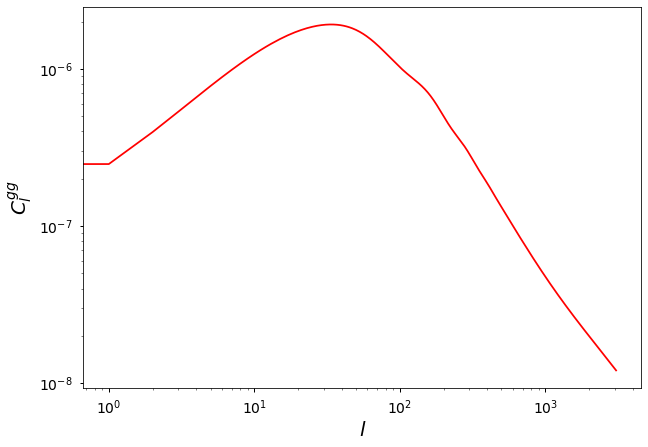

In [6]:
plt.figure(figsize = fsize)
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{g g}_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_elg_th, 'r-')

# 2: Generate a realization and noise map

## Realization

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

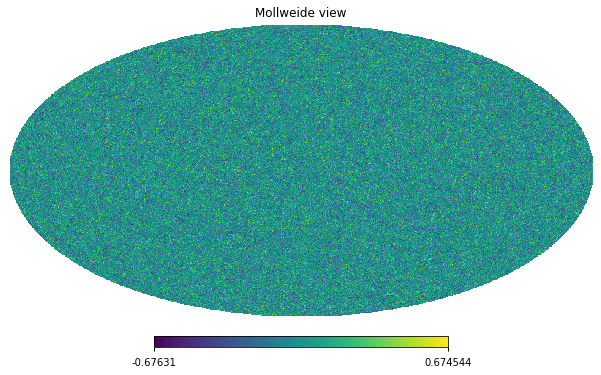

In [7]:
delta_g = hp.synfast(cls_elg_th, nside = NSIDE, pol=False, verbose=False)
hp.mollview(delta_g)

## Noise Map

Compare shot noise, $N_s$ with $C_l$

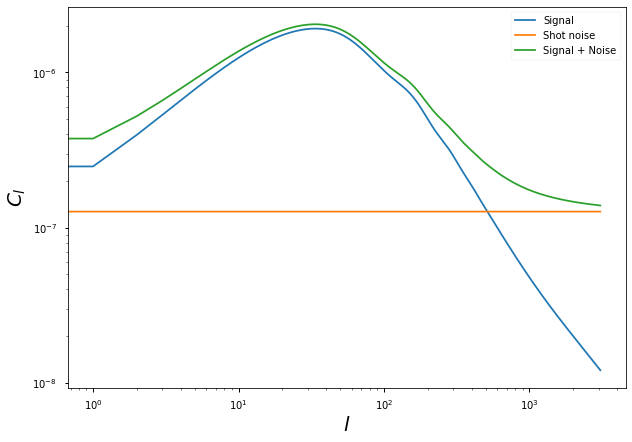

In [8]:
nbar_sqdeg = 2400 #per deg2
nbar_sr = (np.pi/180)**(-2) * nbar_sqdeg #conversion factor from sq deg to sr. 1 deg2 = 4pi^2/129600 sr
cl_shot_noise = 1/nbar_sr * np.ones_like(ell)

plt.figure(figsize = fsize)
plt.loglog(ell, cls_elg_th, label = 'Signal')
plt.loglog(ell, cl_shot_noise, label = 'Shot noise')
plt.loglog(ell, cls_elg_th + cl_shot_noise, label = 'Signal + Noise')
plt.xlabel("$l$", fontsize = fs)
plt.ylabel("$C_l$", fontsize = fs)
plt.legend(loc = 'best')
plt.show()

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

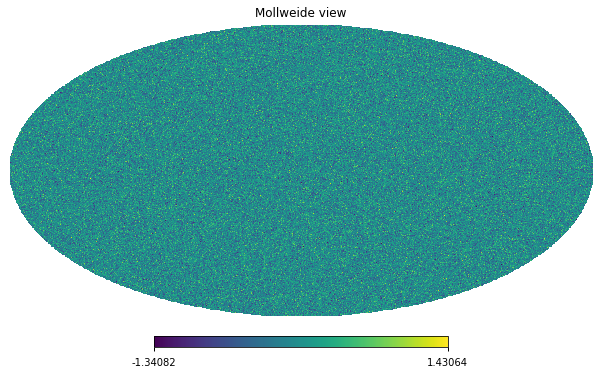

In [9]:
noise_g = hp.synfast(cl_shot_noise, nside = NSIDE, pol = False, verbose = False)
hp.mollview(noise_g)

# 3: Apply imaging systematics 

## Import Mehdi's neural network weight map

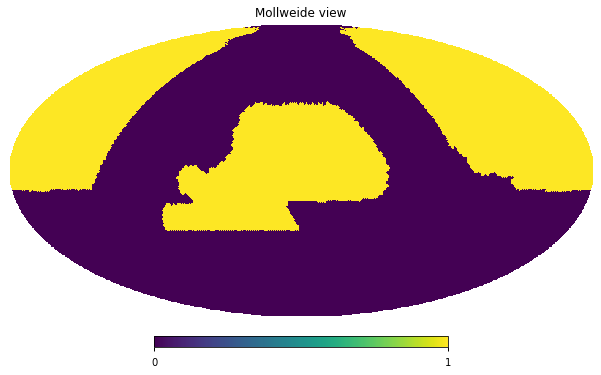

In [10]:
#read in random and degrade it to generate mask
dr_elg_ran = np.load("../dat/elg_ran1024.npy")
dr_elg_ran64 = hp.ud_grade(dr_elg_ran, 64) #make it very coarse to remove weird effects in the middle
dr_elg_ran_final = hp.ud_grade(dr_elg_ran64, NSIDE)

mask = np.copy(dr_elg_ran_final)
mask[dr_elg_ran_final != 0] = 1 #good pixels are 1
mask = mask.astype("bool")
hp.mollview(mask)

In [11]:
# insert at 1, 0 is the script path (or '' in REPL)

from lib import GenSys

gs = GenSys('../dat/nn-weights-combined_1024.fits', nside = NSIDE)          # window functions

#--- contaminate a given density field
delta_c = gs.contaminate(gs.fetch_window(0), delta_g, mask, noisemap = noise_g)

# of selection functions:  (4805767, 100)


### Visualize truth and contaminated maps

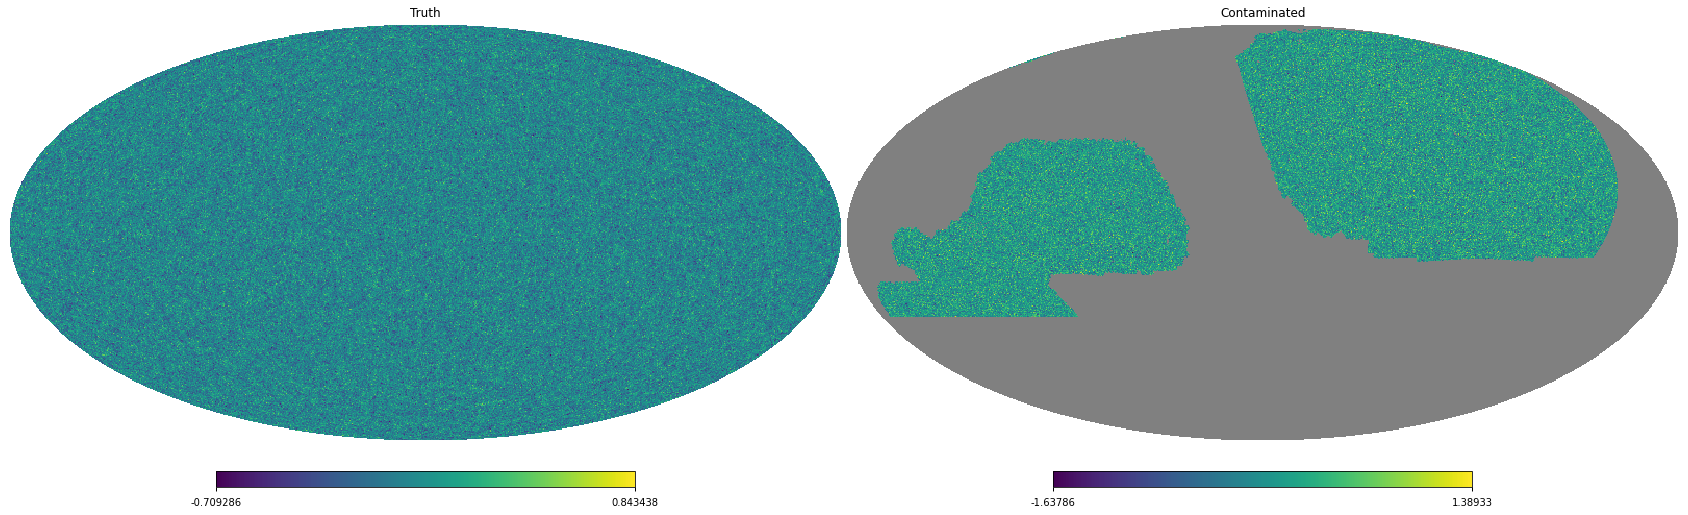

In [12]:
fg, ax = plt.subplots(ncols=2, figsize=(30, 10))
fg.subplots_adjust(wspace=0.0)

for i, (map_i, title_i) in enumerate(zip([delta_g, delta_c],
                                         ['Truth', 'Contaminated'])):
    plt.sca(ax[i])
    hp.mollview(map_i, rot=-85, hold=True, title=title_i)

## Determine average selection function $<F>$

In [13]:
nselfunc = 100 #number of selection functions
Fmean = np.zeros(nselfunc) #store the mean of each selection function
Favg_map = np.zeros(12*NSIDE**2) #store the average selection function

for i in range(nselfunc):
    tmpF = gs.fetch_window(i) #tmp variable to store each call
    maskedMean = np.mean(tmpF[mask > 0]) #temp variable to store mean of each sel. func.
    tmpF = tmpF/maskedMean #Renormalize map to <F> = 1; This is because Mehdi clipped extreme values so <F> != 1
    Fmean[i] = np.mean(tmpF[mask > 0])
    if(i == 0): #define running average
        Favg_map = tmpF
    else:
        Favg_map = (tmpF + i * Favg_map)/(i + 1) 

### Visualize average contaminated map

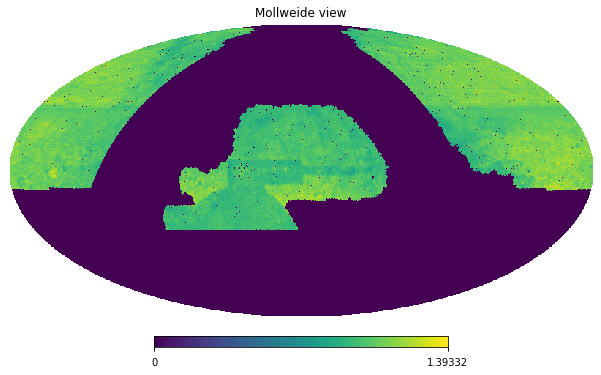

In [14]:
hp.mollview(Favg_map)

# 4: Experiments with different contaminated maps
Here, $F \equiv$ selection function, $\delta_g \equiv$ overdensity map and $N_{s} \equiv$ noise map.

For each experiment, we generate $100$ Gaussian mocks and calculate the covariance matrix.

- A: Fixed Window - $<F> \delta_g + \sqrt{<F>} N_{s}$
- B: Variable Window - $F\delta_g + \sqrt{F} N_{s}$
- C: Variable Window - $F (1 + \delta_g) + \sqrt{F} N_{s} - <F>$

## Experiment A: Fixed Window - $<F> \delta_g + \sqrt{<F>} N_{s}$

In [35]:
from time import time 

In [76]:
def cls_from_mock(cls_th, cls_shot_noise, F, mask, seed, LMAX, NSIDE = 1024, additive = None):
    """Generate a mock given conditions and calculate pseudo-Cls from the mock.

    Inputs:
        cls_th (np.array) : array of theory Cl values to be used to generate
                            mock
        cls_shot_noise (np.array) : array of Cl values to be used to generate
                                    noise mock
        F (np.array) : Imaging contaminant map from GenSys. Should be same size
                        as NSIDE
        mask (np.array) : Mask map. Should be same size as NSIDE
        seed (int) : seed for mock generation
        LMAX (int) : lmax to be calculated for pseudo Cl
        NSIDE (int) : nside for healpy

    Returns:
        cls_obs (np.array) : array of pseudo-Cls based on generated mock. Not
                            corrected for fsky
    """

    #generate overdensity signal mock
    np.random.seed(seed)
    delta_g = hp.synfast(cls_th,
        nside = NSIDE, lmax = LMAX, pol=False, verbose=False)

    #generate noise mock
    np.random.seed(2*seed + 1029) #random different seed for noise
    noise_g = hp.synfast(cls_shot_noise,
        nside = NSIDE, lmax = LMAX, pol = False, verbose = False)

    #add img sys
    if additive is not None:
        delta_c = gs.contaminate(F, delta_g, mask, noisemap = noise_g, additive = additive)
    else:
        delta_c = gs.contaminate(F, delta_g, mask, noisemap = noise_g)

    #calcuate pseudo-Cl
    cls_obs = hp.anafast(delta_c, lmax = LMAX -1, pol = False)

    return cls_obs

In [43]:
start = time()
cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = Favg_map, 
              mask = mask, seed = 67, LMAX = LMAX)
runtime = time() - start
print(runtime)

4.598601341247559


In [56]:
NMOCKS = 1000
cls_obs_A = np.zeros((NMOCKS, LMAX))

#calculate window noise
noise_window = np.mean(Favg_map)*1/nbar_sr

#calculate fsky
fsky = np.sum(mask)/mask.shape[0] 

#corrected for window noise and fsky
for i in range(NMOCKS):
    cls_obs_A[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = Favg_map, 
              mask = mask, seed = 67 + 2*i, LMAX = LMAX) - noise_window)/fsky
    if((i % (100)) == 0):
        print(i)

0
100
200
300
400
500
600
700
800
900


In [57]:
import itertools
def bin_mat(r=[],mat=[],r_bins=[]):
    """Sukhdeep's Code to bins data and covariance arrays

    Input:
    -----
        r  : array which will be used to bin data, e.g. ell values
        mat : array or matrix which will be binned, e.g. Cl values
        bins : array that defines the left edge of the bins,
               bins is the same unit as r

    Output:
    ------
        bin_center : array of mid-point of the bins, e.g. ELL values
        mat_int : binned array or matrix
    """

    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

In [58]:
ELL = np.logspace(0, 3, 10)
CLs_obs_A = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_A[i] = bin_mat(ell, cls_obs_A[i], ELL)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Calculate covariance matrix and visualize

<AxesSubplot:>

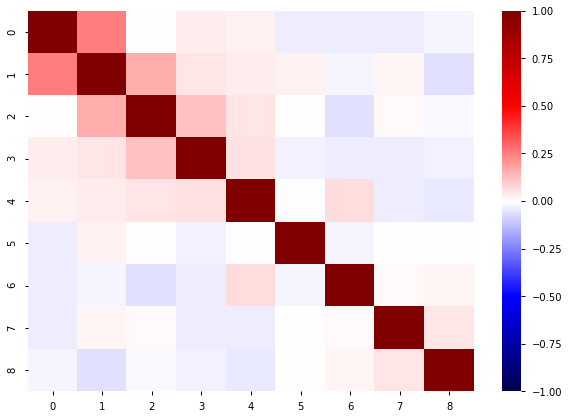

In [59]:
covmat_A = np.corrcoef(CLs_obs_A.T)

plt.figure(figsize = fsize)
sns.heatmap(covmat_A, cmap = 'seismic', vmin = -1, vmax = +1)

## Experiment B: Variable Window - $F\delta_g + \sqrt{F} N_{s}$

We use the same Gaussian realizations and noise realizations

In [66]:
start = time()
cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = gs.fetch_window(np.random.randint(low = 0, high = 100)), 
              mask = mask, seed = 670, LMAX = LMAX)
runtime = time() - start
print(runtime)

5.033973932266235


In [67]:
NMOCKS = 1000
cls_obs_B = np.zeros((NMOCKS, LMAX))

#calculate fsky
fsky = np.sum(mask)/mask.shape[0] 

#corrected for window noise and fsky
for i in range(NMOCKS):
    #call one of the 100 img systematics models
    F = gs.fetch_window(np.random.randint(low = 0, high = 100))
    
    #calculate window noise
    noise_window = np.mean(F)*1/nbar_sr
    
    cls_obs_B[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = F, 
              mask = mask, seed = 670 + 2*i, LMAX = LMAX) - noise_window)/fsky
    if((i % (100)) == 0):
        print(i)

0
100
200
300
400
500
600
700
800
900


In [69]:
CLs_obs_B = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_B[i] = bin_mat(ell, cls_obs_B[i], ELL)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


<AxesSubplot:>

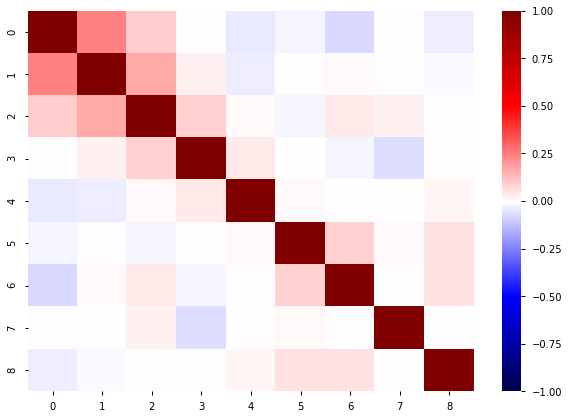

In [70]:
covmat_B = np.corrcoef(CLs_obs_B.T)

plt.figure(figsize = fsize)
sns.heatmap(covmat_B, cmap = 'seismic', vmin = -1, vmax = +1)

<AxesSubplot:>

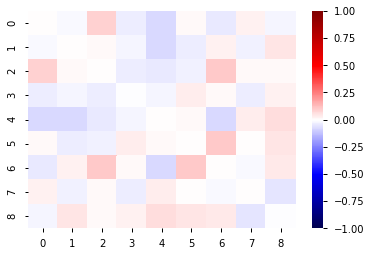

In [72]:
sns.heatmap(covmat_B-covmat_A, cmap = 'seismic', vmin = -1, vmax = +1)

## Experiment C: Variable Window - $F (1 + \delta_g) + \sqrt{F} N_{s} - <F>$

In [77]:
start = time()
cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = gs.fetch_window(np.random.randint(low = 0, high = 100)), 
              mask = mask, seed = 670, LMAX = LMAX, additive=Favg_map)
runtime = time() - start
print(runtime)

4.6739983558654785


In [78]:
NMOCKS = 1000
cls_obs_C = np.zeros((NMOCKS, LMAX))

#calculate fsky
fsky = np.sum(mask)/mask.shape[0] 

#corrected for window noise and fsky
for i in range(NMOCKS):
    #call one of the 100 img systematics models
    F = gs.fetch_window(np.random.randint(low = 0, high = 100))
    
    #calculate window noise
    noise_window = np.mean(F)*1/nbar_sr
    
    cls_obs_C[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = F, 
              mask = mask, seed = 670 + 2*i, LMAX = LMAX, additive=Favg_map) - noise_window)/fsky
    if((i % (100)) == 0):
        print(i)

0
100
200
300
400
500
600
700
800
900


In [79]:
CLs_obs_C = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_C[i] = bin_mat(ell, cls_obs_C[i], ELL)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


<AxesSubplot:>

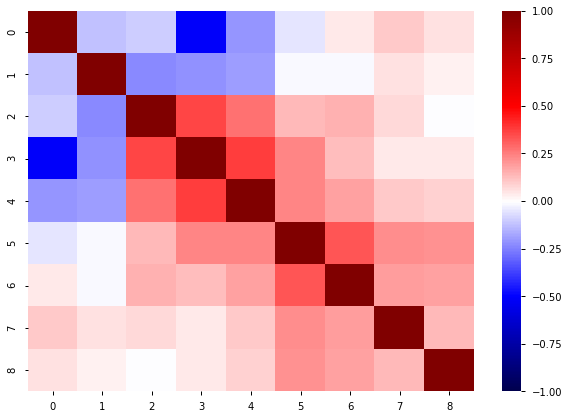

In [80]:
covmat_C = np.corrcoef(CLs_obs_C.T)

plt.figure(figsize = fsize)
sns.heatmap(covmat_C, cmap = 'seismic', vmin = -1, vmax = +1)

<AxesSubplot:>

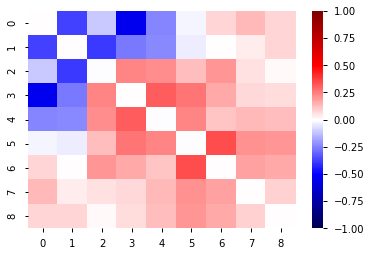

In [81]:
sns.heatmap(covmat_C-covmat_A, cmap = 'seismic', vmin = -1, vmax = +1)

Save the covariance matrices

In [82]:
np.save("../dat/cls_expA.npy", cls_obs_A)
np.save("../dat/cls_expB.npy", cls_obs_B)
np.save("../dat/cls_expC.npy", cls_obs_C)

## Test with SFD EBV map

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

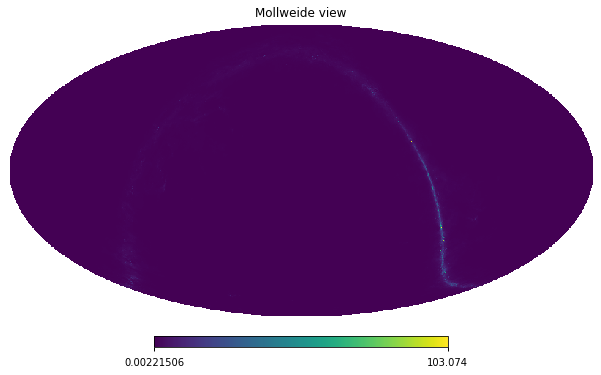

In [100]:
ebv = hp.read_map("../dat/healSFD_256_fullsky.fits", )

hp.mollview(ebv)

### Clean mock X EBV

In [101]:
cl_clean_ebv = hp.anafast(delta_g[0], ebv, lmax = lmax - 1)

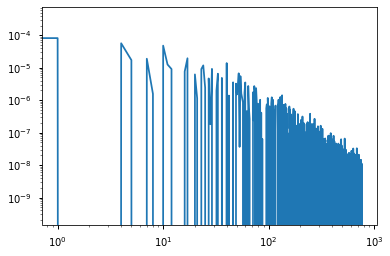

In [103]:
plt.loglog(ell, cl_clean_ebv)

### Contaminated mock X EBV

In [104]:
cl_contam_ebv = hp.anafast(delta_c[0], ebv, lmax = lmax - 1)

(-5.0, 10.0)

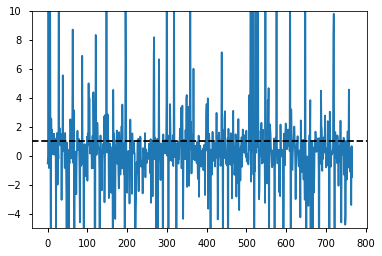

In [112]:
plt.plot(ell, cl_contam_ebv/cl_clean_ebv)
plt.axhline(1, c = 'k', ls = '--')
plt.ylim([-5, 10])

### Window X EBV

In [120]:
cl_win_ebv = hp.anafast(gs.fetch_window(0), ebv, lmax = lmax - 1)

(-5.0, 10.0)

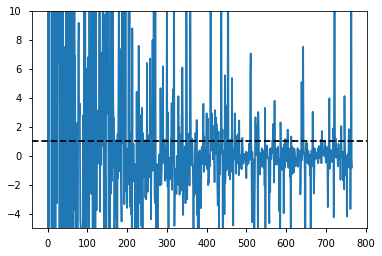

In [121]:
plt.plot(ell, cl_win_ebv/cl_clean_ebv)
plt.axhline(1, c = 'k', ls = '--')
plt.ylim([-5, 10])

In [ ]:
plt.figure(figsize = fsize)
plt.loglog(ell, cl_clean_ebv, alpha = 0.5, label = 'Clean X EBV')
plt.loglog(ell, cl_contam_ebv, alpha = 0.5, label = 'Contaminated X EBV')
plt.loglog(ell, cl_win_ebv, alpha = 0.5, label = 'Window X EBV')
plt.xlabel("l", fontsize = fs)
plt.ylabel(r"$C_{l}^{EBV \times \delta}$", fontsize = fs)
plt.legend(loc = 'best')